## Can You Turn America’s Pastime Into A Game Of Yahtzee?

### Part 1: Riddler Express
Given the rule of Our National Pastime, what’s the average number of runs that would be scored in nine innings of this dice game? What’s the distribution of the number of runs scored? (Histograms welcome.) You can assume some standard baseball things, like runners scoring from second on singles and runners scoring from third on fly outs.

### Part 2: Riddler Classic

You get to work making your own list of dice rolls, tweaking what corresponds to each roll to better match the real distributions of baseball run scores. You should be using that same set of standard baseball assumptions about when runners score (sacrifice flies, runners scoring from second, etc.).

Once you’ve matched the run-scoring environment, try to add other variables to your computations. What if you try to simulate strikeouts per game, batting average, etc.?

### Part 3: One Die Game 

For fun, I tried to create a one die version. Looking at the stats, it looked a lot like little league games I have watched.

### Part 4: Trading Cards

As a kid, I loved looking at trading cards and trying to determine what would happen. In Part 4, each player would create a lineup that would face the opposing player's pitcher. Using stats from the back of the cards, the hitter or pitcher could get an advantage that would be be applied to the dice roll.    

![](https://kronozio.blob.core.windows.net/images/card/3feb544f651048df8fb05df9e2b272c7_back.jpg)

## Summary

### Part 1
14.5 runs/game.  See histogram at bottom of notebook

### Part 2
These rules matched on all 12 stats I included.  I did not generate triples or steals because they are so rare.

11:'home run',
12:'double',
13:'single',
14:'single',
15:'single',
16:'base on balls'

22:'base on error',
23:'strike out',
24:'strike out',
25:'strike out',
26:'strike out',

33:'force out',
34:'force out',
35:'force out',
36:'force out',

44:'force out',
45:'force out',
46:'fly out',

55:'fly out',
56:'fly out',

66:'foul out'

### Part 3

1:'single',
2:'base on balls',
3:'strike out',
4:'force out',
5:'fly out',
6:'steal'

As like a real little league game, there were many more walks, steals, and fly outs.


### Part 4

To make the game more realistic, I made dice order matter and added or subtracted from the dice based on the difference in ability between pitcher and hitter. I also gave small boosts to the first batter (speed) and clean up hitter (power).  These tweaks allowed me to add and match steals and triples.

11:'home run',
12:'home run',
13:'double', (homerun for cleanup, triple for leadoff)
14:'double',
15:'single',
16:'force out',

21:'single', 
22:'single',
23:'single',
24:'out at 1st',
25:'force out',
26:'fly out',

31:'base on balls',
32:'base on balls',
33:'base on balls',
34:'strike out',
35:'strike out',
36:'strike out',

41:'base on error',
42:'strike out',
43:'strike out',
44:'strike out',
45:'strike out',
46:'strike out',

51:'base on balls',
52:'out at 1st',
53:'fly out',
54:'fly out',
55:'fly out',
56:'foul out',

61:'steal',
62:'out at 1st',
63:'force out',
64:'force out',
65:'force out',
66:'double play'

### Details
Each simulation is 30 teams playing 162 games.  Averages and standard deviation are of team level stats.
In the tables at the bottom, the values are mean +/- standard deviation.  The Z score is difference between the simulation mean and the reference mean divided by the reference standard deviation.

Z scores between -3 and 3, I considered matched.  

### Code
I wrote the code to make it easy to try different dice mechanisms.  The user supplies a dice function and reference stats and the simulator creates a table comparison. Skip to the bottom of the notebook to see the output.



### Setup Code


In [1]:
import random
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, HTML



In [2]:
#MLB 2018 Stats
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

TESTDATA = StringIO("""stats;mean;std
    Single; 877;58 
    Double; 277;29
    Triple; 28;9 
    HomeRun; 186;32
    FlyOut; 800;45 
    FoulOut; 200;15
    StrikeOut; 1374;100 
    GroundOut; 1875;97
    DoublePlay; 117;14 
    RBI; 687;72
    BaseOnBalls; 523;64 
    BaseOnError; 90;26
    Steals; 82;26
    Sacrifices; 68;13
    """)

df_2018 = pd.read_csv(TESTDATA, sep=";")

In [10]:
#Functions to simplify simulation code
def Walk(First, Second, Third, Runs):
    if First & Second & Third:
        Runs = Runs+1
    elif First & Second:
        Third = True
    elif First:
        Second = True
    else:
        First = True
    return (First, Second, Third, Runs)
        

def ScoreAll(First,Second,Third, Runs):
    Runs, Third = Score(Runs, Third)
    Runs, Second = Score(Runs, Second)
    Runs, First = Score(Runs, First)
    return (First, Second, Third, Runs)
                
def Score(Runs,Base):
    if Base:
        Base = False
        Runs = Runs+1
    return (Runs, Base)

def Advance(StartBase,EndBase):
    if StartBase:
        EndBase = True
        StartBase = False
    return (StartBase,EndBase)

def AdvanceAll(First, Second, Third, Runs):
    Runs, Third = Score(Runs, Third)
    Second, Third = Advance(Second,Third)
    First, Second = Advance(First,Second)
    
    return (First, Second, Third, Runs)

def ForceOut(First, Second, Third, Runs,GroundOut, DoublePlay,Outs):
    if First & Second & Third:
        Third = False
        DoublePlay = DoublePlay +1
        Outs = Outs + 2
    elif First & Second:
        Second = False
        DoublePlay = DoublePlay +1
        Outs = Outs + 2
    elif First & Third:
        DoublePlay = DoublePlay +1
        Outs = Outs + 2
        if Outs <3:
            Runs, Third = Score(Runs, Third)
    elif First:
        DoublePlay = DoublePlay +1
        Outs = Outs + 2
    else:
        #Play at First
        GroundOut = GroundOut+1
        Outs = Outs +1
        First, Second, Third, Runs = AdvanceAll(First, Second, Third, Runs)
    return (First, Second, Third, Runs,GroundOut, DoublePlay,Outs)

def TurnDoublePlay(First, Second, Third, Runs):
    if First & Second & Third:
        First = False 
    elif First & Second:
        First = False
        Second = False
        Third = True
    elif First & Third:
        First = False
        Runs, Third = Score(Runs, Third)
    elif First:
        First = False
    elif Second & Third:
        #Not sure about this one. Unusual situation for a double play
        Second = False
    elif Second:
        Second = False
    return (First, Second, Third, Runs)

In [49]:
#Main code -- supply dice function and reference stats.
def PlaySeason(UserDice, df_2018,ReturnRuns=False):
#f 1 ==1:
    rolldice = UserDice
    #olldice = rolldice_playingcards
    FlyOut=0
    StrikeOut=0
    FoulOut = 0
    Single = 0
    Double = 0
    Triple = 0
    HomeRun = 0
    BaseOnBalls = 0
    BaseOnError = 0
    DoublePlay = 0
    GroundOut = 0
    Steals = 0
    Sacrifice = 0

    Home_list = []
    Away_list = []
    FlyOut_list = []
    StrikeOut_list = []
    FoulOut_list = []
    Single_list = []
    Double_list = []
    Triple_list = []
    HomeRun_list = []
    BaseOnBalls_list = []
    BaseOnError_list = []
    DoublePlay_list = []
    GroundOut_list = []
    RBI_list = []
    Steal_list = []
    Sacrifice_list = []
    AB = [1,1]
    #30 Franchise
    for Franchises in range(30):
        FlyOut=0
        StrikeOut=0
        FoulOut = 0
        Single = 0
        Double = 0
        Triple = 0
        HomeRun = 0
        BaseOnBalls = 0
        BaseOnError = 0
        DoublePlay = 0
        GroundOut = 0
        RBI = 0
        Steal = 0
        Sacrifice = 0
        #One Team (count both home and away stats for one team)
        for Game in range(81):
            #Initialize Game
            Inning = 1
            Home = 0
            Away = 0
            AB[0] = 1
            AB[1] = 1
            

            while (Inning < 10) | (Home == Away):
                for Team in range(2):
                    if (Home > Away) & (Inning>8):
                        pass #Skip bottom of 9th
                    else:
                        Outs = 0
                        Strike =0
                        Runs = 0
                        First = False
                        Second = False
                        Third = False
                        while Outs < 3:
                            Batter = rolldice(AB[Team])
                            #print (Batter)
                            if Batter == "strike":
                                Strike = Strike+1
                                if Strike == 3:
                                    Outs=Outs+1
                                    StrikeOut=StrikeOut+1
                                    Strike = 0
                            else:
                                Strike = 0

                            if Batter == "strike out": 
                                Outs = Outs+1
                                StrikeOut = StrikeOut+1

                            if Batter == "foul out": 
                                Outs = Outs+1
                                FoulOut = FoulOut+1

                            if Batter == "fly out":
                                
                                Outs = Outs+1
                                if (Outs<3) & (First|Second|Third):
                                    First, Second, Third, Runs = AdvanceAll(First, Second, Third, Runs)
                                    Sacrifice=Sacrifice+1
                                else:
                                    FlyOut = FlyOut +1

                            if Batter == "out at 1st":
                                Outs = Outs + 1 
                                GroundOut = GroundOut+1
                                if Outs < 3:
                                    First, Second, Third, Runs = AdvanceAll(First, Second, Third, Runs)

                            if Batter == "force out":
                                if Outs == 2:
                                    Outs = Outs + 1
                                    GroundOut = GroundOut+1
                                else:
                                    First, Second, Third, Runs, GroundOut, DoublePlay, Outs = ForceOut(
                                        First, Second, Third, Runs,GroundOut,DoublePlay, Outs)

                            if Batter == "double play":
                                if First | Second | Third:
                                    Outs = Outs + 2
                                    if Outs == 4:
                                        GroundOut = GroundOut+1
                                    else:
                                        DoublePlay = DoublePlay +1
                                    if Outs <3:
                                        First, Second, Third, Runs = TurnDoublePlay(First, Second, Third, Runs)
                                else:
                                    Outs = Outs +1
                                    GroundOut = GroundOut+1

                            if Batter == "base on balls":
                                First, Second, Third, Runs = Walk(First, Second, Third, Runs)
                                First = True
                                BaseOnBalls = BaseOnBalls+1

                            if Batter == "steal":
                                First, Second, Third, Runs = AdvanceAll(First, Second, Third, Runs)
                                if First | Second | Third :
                                    Steal = Steal + 1

                            if Batter == "base on error":
                                Runs, Third = Score(Runs, Third)
                                Runs, Second = Score(Runs, Second)
                                First, Third = Advance(First,Third)
                                BaseOnError = BaseOnError+1

                            if Batter == "single": 
                                Runs, Third = Score(Runs, Third)
                                Runs, Second = Score(Runs, Second)
                                First, Third = Advance(First,Third)
                                Single = Single+1

                            if Batter == "double":
                                First,Second,Third,Runs = ScoreAll(First,Second,Third,Runs)
                                Second = True
                                Double = Double + 1

                            if Batter == "triple": 
                                First,Second,Third,Runs = ScoreAll(First,Second,Third,Runs)
                                Third = True
                                Triple = Triple + 1

                            if Batter == "home run": 
                                First,Second,Third,Runs = ScoreAll(First,Second,Third,Runs)
                                Runs=Runs+1
                                HomeRun=HomeRun+1
                            
                            AB[Team] = AB[Team]+1
                            if AB[Team] > 9:
                                AB[Team]=1

                            #Outs = Outs+1
                        if Team ==1:
                            Away = Away+Runs
                        else:    
                            Home = Home+Runs

                #print (Inning,Home,Away)
                Inning = Inning + 1
            Home_list.append(Home)
            Away_list.append(Away)
            RBI = RBI + Home + Away
        #End of Franchise     
        FlyOut_list.append(FlyOut)
        StrikeOut_list.append(StrikeOut)
        FoulOut_list.append(FoulOut)
        Single_list.append(Single)
        Double_list.append(Double)
        Triple_list.append(Triple)
        HomeRun_list.append(HomeRun)
        BaseOnBalls_list.append(BaseOnBalls)
        BaseOnError_list.append(BaseOnError)
        DoublePlay_list.append(DoublePlay)
        GroundOut_list.append(GroundOut)
        RBI_list.append(RBI)
        Steal_list.append(Steal)
        Sacrifice_list.append(Sacrifice)
        
    #Summarize Results    
    df = pd.DataFrame({'Single': Single_list, 
                   'Double': Double_list,
                   'Triple': Triple_list, 
                   'HomeRun': HomeRun_list,
                   'FlyOut': FlyOut_list, 
                   'FoulOut': FoulOut_list,
                   'StrikeOut': StrikeOut_list, 
                   'GroundOut': GroundOut_list,
                   'DoublePlay': DoublePlay_list, 
                   'RBI': RBI_list,
                   'BaseOnBalls': BaseOnBalls_list, 
                   'BaseOnError': BaseOnError_list,
                   'Steals': Steal_list,
                   'Sacrifices': Sacrifice_list
                  })
    
    if ReturnRuns:
        return df['RBI'].mean()/162
    else:
        df2 = pd.DataFrame({'mean':df.mean(), 'std':df.std()})
        #df2=df2.set_index(df2.index)
        df_2018=df_2018.set_index(df2.index)

        df2['mean'] = df2['mean'].map(int)
        df2['std'] = df2['std'].map(int)

        df3 = df2.join(df_2018,lsuffix='_Sim',rsuffix='_2018')
        df3['Simulation'] = df3['mean_Sim'].map(str) + " +/- " + df3['std_Sim'].map(str)
        df3['2018']=  df3['mean_2018'].map(str) + " +/- " + df3['std_2018'].map(str)
        df3['Z']= (((df3['mean_Sim'] - df3['mean_2018'])/df3['std_2018'])*10).map(int)/10
        display(HTML(df3[['Simulation','2018','Z']].to_html()))
        return 0

## Define the Dice Rules

In [41]:
def rolldice1(AB):
    a = random.randint(1,6)
    b = random.randint(1,6)
    if a>b:
        i = b*10+a
    else:
        i = a*10+b
    switcher={
            11:'double',
            12:'single',
            13:'single',
            14:'single',
            15:'base on error',
            16:'base on balls',
            22:'strike',
            23:'strike',
            24:'strike',
            25:'strike',
            26:'foul out',
            33:'out at 1st',
            34:'out at 1st',
            35:'out at 1st',
            36:'out at 1st',
            44:'fly out',
            45:'fly out',
            46:'fly out',
            55:'double play',
            56:'triple',
            66:'home run'
         }
    return switcher.get(i,"Invalid roll")

In [42]:
def rolldice2(AB):
    a = random.randint(1,6)
    b = random.randint(1,6)
    if a>b:
        i = b*10+a
    else:
        i = a*10+b
    switcher={
            11:'home run',
            12:'double',
            13:'single',
            14:'single',
            15:'single',
            16:'base on balls',
            22:'base on error',
            23:'strike out',
            24:'strike out',
            25:'strike out',
            26:'strike out',
            33:'force out',
            34:'force out',
            35:'force out',
            36:'force out',
            44:'force out',
            45:'force out',
            46:'fly out',
            55:'fly out',
            56:'fly out',
            66:'foul out'
         }
    return switcher.get(i,"Invalid roll")

In [43]:
#Just for fun -- use this die to simulate a little league game
def rolldice_littleleague(AB):
    a = random.randint(1,6)
    
    switcher={
            1:'single',
            2:'base on balls',
            3:'strike out',
            4:'force out',
            5:'fly out',
            6:'steal'
         }
    return switcher.get(a,"Invalid roll")

In [44]:
def rolldice_playingcards(AB):
    a = random.randint(1,6)
    b = random.randint(1,6)
    
    #Pitcher and Hitter are ranked 1,2, 3
    #3 = Above Average
    #2 = Average
    #1 = Below Average
    
    #If really playing game would use stats on the back of the cards to determine
    pitcher_hitter = random.randint(-2,2)
    
    #Pitcher much better add one to both dies
    #Pitcher better add to one to modifying die
    #Hitter is reverse
    
    
    if pitcher_hitter == 2 & a < 6:
        a = a +1
    if pitcher_hitter == -2 & a >1:
        a= a - 1
    if pitcher_hitter > 0 & b < 6:
        b = b +1
    if pitcher_hitter <0 & b >1:
        b = b - 1

        
    i = 10*a + b    
    #Not used but for illustration
    BaseCase={
            1:'hit',
            2:'hit',
            3:'base on balls',
            4:'strike out',
            5:'force out',
            6:'fly out'
         }
    #
    switcher={   
    11:'home run',
    12:'home run',
    13:'double',
    14:'double',
    15:'single',
    16:'force out',
    21:'single',
    22:'single',
    23:'single',
    24:'out at 1st',
    25:'force out',
    26:'fly out',
    31:'base on balls',
    32:'base on balls',
    33:'base on balls',
    34:'strike out',
    35:'strike out',
    36:'strike out',
    41:'base on error',
    42:'strike out',
    43:'strike out',
    44:'strike out',
    45:'strike out',
    46:'strike out',
    51:'base on balls',
    52:'out at 1st',
    53:'fly out',
    54:'fly out',
    55:'fly out',
    56:'foul out',
    61:'steal',
    62:'out at 1st',
    63:'force out',
    64:'force out',
    65:'force out',
    66:'double play'
      }
    
    if AB==1:
        switcher[13]='triple'
    if AB==4:
        switcher[13]='home run'
    return switcher.get(i,"Invalid roll")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000004879E089E8>]],
      dtype=object)

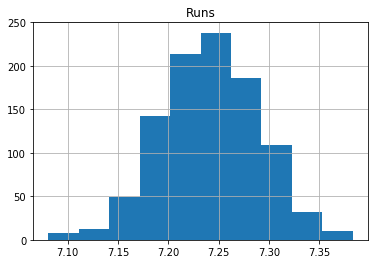

In [25]:
Runs=[]
for i in range(1000):
    Runs.append(PlaySeason(rolldice1,df_2018,True))

df = pd.DataFrame({'Runs': Runs})
df.hist()
    

In [50]:
display("Express")
tmp = PlaySeason(rolldice1,df_2018)
display("Classic")
tmp = PlaySeason(rolldice2,df_2018)
display("Little League")
tmp = PlaySeason(rolldice_littleleague,df_2018)
display("Trading Cards")
tmp = PlaySeason(rolldice_playingcards,df_2018)

'Express'

,Simulation,2018,Z
Single,1620 +/- 44,877 +/- 58,12.8
Double,267 +/- 18,277 +/- 29,-0.3
Triple,537 +/- 20,28 +/- 9,56.5
HomeRun,266 +/- 16,186 +/- 32,2.5
FlyOut,1158 +/- 26,800 +/- 45,7.9
FoulOut,540 +/- 23,200 +/- 15,22.6
StrikeOut,58 +/- 7,1374 +/- 100,-13.1
GroundOut,2123 +/- 31,1875 +/- 97,2.5
DoublePlay,39 +/- 7,117 +/- 14,-5.5
RBI,1173 +/- 45,687 +/- 72,6.7


'Classic'

,Simulation,2018,Z
Single,1048 +/- 39,877 +/- 58,2.9
Double,348 +/- 23,277 +/- 29,2.4
Triple,0 +/- 0,28 +/- 9,-3.1
HomeRun,173 +/- 14,186 +/- 32,-0.4
FlyOut,778 +/- 26,800 +/- 45,-0.4
FoulOut,171 +/- 13,200 +/- 15,-1.9
StrikeOut,1387 +/- 34,1374 +/- 100,0.1
GroundOut,1674 +/- 32,1875 +/- 97,-2.0
DoublePlay,76 +/- 7,117 +/- 14,-2.9
RBI,469 +/- 27,687 +/- 72,-3.0


'Little League'

,Simulation,2018,Z
Single,1381 +/- 60,877 +/- 58,8.6
Double,0 +/- 0,277 +/- 29,-9.5
Triple,0 +/- 0,28 +/- 9,-3.1
HomeRun,0 +/- 0,186 +/- 32,-5.8
FlyOut,1113 +/- 26,800 +/- 45,6.9
FoulOut,0 +/- 0,200 +/- 15,-13.3
StrikeOut,1349 +/- 35,1374 +/- 100,-0.2
GroundOut,1206 +/- 34,1875 +/- 97,-6.8
DoublePlay,169 +/- 10,117 +/- 14,3.7
RBI,545 +/- 20,687 +/- 72,-1.9


'Trading Cards'

,Simulation,2018,Z
Single,764 +/- 34,877 +/- 58,-1.9
Double,272 +/- 17,277 +/- 29,-0.1
Triple,19 +/- 4,28 +/- 9,-1.0
HomeRun,244 +/- 17,186 +/- 32,1.8
FlyOut,701 +/- 21,800 +/- 45,-2.2
FoulOut,185 +/- 15,200 +/- 15,-1.0
StrikeOut,1410 +/- 30,1374 +/- 100,0.3
GroundOut,1671 +/- 42,1875 +/- 97,-2.1
DoublePlay,87 +/- 7,117 +/- 14,-2.1
RBI,556 +/- 29,687 +/- 72,-1.8
